# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from scipy.cluster.vq import vq
from sklearn.metrics.cluster import homogeneity_score

# Data 

In [2]:
# read .mat files
train = sio.loadmat('data/train_32x32.mat')
test = sio.loadmat('data/test_32x32.mat')
# extract data and labels
train_data: np.ndarray = train['X']
train_labels: np.ndarray = train['y']
test_data: np.ndarray = test['X']
test_labels: np.ndarray = test['y']

# Data reshape and sampling

In [49]:
trd_reshape = train_data.reshape(3072, train_data.shape[3]).T
print(trd_reshape[:2])
ted_reshape = test_data.reshape(3072, test_data.shape[3]).T
zipped = list(zip(trd_reshape, train_labels))
np.random.shuffle(zipped)
srt = sorted(zipped, key=lambda x: x[1])
print(len(srt))
out = []
old_labels = []
x = -1
for i, q in enumerate(srt):
  if q[1] != x:
    # New label
    out += list(map(lambda w: w[0], srt[i:i+2500]))
    old_labels += list(map(lambda w: w[1], srt[i:i+2500]))
    x = q[1]

trd_new = out
print(len(out), len(old_labels))

[[ 33  30  38 ... 103 106  79]
 [ 84  76  59 ... 103  98  80]]
73257
25000 25000


In [50]:
labels = list(map(lambda x: x[0], old_labels))
labels = np.array(labels)
labels

array([ 1,  1,  1, ..., 10, 10, 10], dtype=uint8)

# Question 1

## Perform PCA

In [4]:
def train_pca(i) -> (PCA, np.ndarray, np.ndarray):
    pca = PCA(n_components=i)
    pca.fit(trd_new)
    train_data_pca = pca.transform(trd_new)
    test_data_pca = pca.transform(ted_reshape)
    return pca, train_data_pca, test_data_pca


### Get dimiensions for 0.9 PoV

In [5]:
pca, tr, te = train_pca(3072)

### Plot the PoV

PoV = 0.900 > 0.9 achieved at 26 dimensions


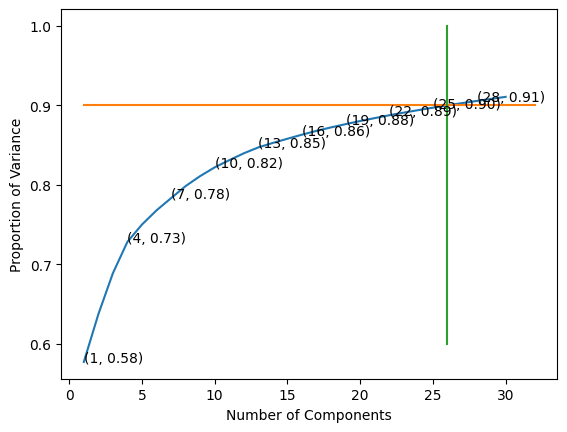

In [6]:
cum = np.cumsum(pca.explained_variance_ratio_)

q = cum[:30]
plt.plot(range(1, 31), q)
plt.xlabel('Number of Components')
plt.ylabel('Proportion of Variance') #for each component
v = 0
for i in range(1, 31, 3):
    plt.annotate(f'({i}, {q[i-1]:.2f})', (i, q[i-1]))
    if q[i-1] >= 0.9:
        v = i
        break

plt.plot(np.linspace(1, 32, 320), [0.9] * 320)
plt.plot([v - 2] * 320, np.linspace(0.6, 1.0, 320))
print(f'PoV = {q[25]:.3f} > 0.9 achieved at {v - 2} dimensions')
plt.show()

In [ ]:
plt.plot(cum)
plt.xlabel('Number of Components')
plt.ylabel('Proportion of Variance')
plt.show()

In [18]:
_, tr_pca_1, te_pca_1 = train_pca(v - 2)
pca, tr_pca_2, te_pca_2 = train_pca(10)

In [19]:
tr_pca_1.shape, te_pca_1.shape, tr_pca_2.shape, te_pca_2.shape

((25000, 26), (26032, 26), (25000, 10), (26032, 10))

## Visualise PCA components

In [29]:
imgs = pca.inverse_transform(tr_pca_2)[:10].reshape(10, 32, 32, 3)
px_labels = [str(i) for i in range(1, 11)]
fig = px.imshow(imgs, facet_col=0, facet_col_wrap=5, labels={'facet_col': 'Principal Component'}, title='Principal Components')
fig.show()


[72973.77617004 76911.43725686 83588.66373433 ... 67266.19229171
 70496.92440352 78146.48385566]
[4536858.986349    469488.82427395  405542.06580013  313258.76326183
  173207.16519896  140998.56448369  121880.44151535  118448.39226299
   99244.78672921   89554.54276224]


## Perform kNN classification

In [35]:
def knn(k) -> (float, float, float):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(trd_new, labels)
    x = accuracy_score(test_labels, knn.predict(ted_reshape))
    knn.fit(tr_pca_1, labels)
    y = accuracy_score(test_labels, knn.predict(te_pca_1))
    knn.fit(tr_pca_2, labels)
    z = accuracy_score(test_labels, knn.predict(te_pca_2))
    return (x, y, z)

(knn(5), knn(7))

/opt/homebrew/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/homebrew/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/homebrew/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/homebrew/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

((0.40277350952673635, 0.39535955746773205, 0.25195912722802705),
 (0.41160878918254457, 0.40769053472649047, 0.2609096496619545))

In [49]:
# np.savetxt('tr_pca_2.csv', tr_pca_1, delimiter=',') # The dimensions = 10 dataset.

# Question 2

## Perform K-means clustering on the training data

In [54]:
def img_closest(kmeans, data):
    closest, _ = vq(kmeans.cluster_centers_, data)
    q = np.array([trd_new[i].reshape(32, 32, 3) for i in closest])
    fig = px.imshow(q, facet_col=0, facet_col_wrap=5, labels={'facet_col': 'Cluster'}, title='Clusters')
    fig.show()

In [55]:
# k-means clustering for trd_new

kmeans_all = KMeans(n_clusters=10, random_state=0, n_init='auto').fit(trd_new)
kmeans_pca_1 = KMeans(n_clusters=10, random_state=0, n_init='auto').fit(tr_pca_1)
kmeans_pca_2 = KMeans(n_clusters=10, random_state=0, n_init='auto').fit(tr_pca_2)

img_closest(kmeans_all, trd_new)
img_closest(kmeans_pca_1, tr_pca_1)
img_closest(kmeans_pca_2, tr_pca_2)

In [57]:
homogeneity_score(labels, kmeans_all.labels_),
homogeneity_score(labels, kmeans_pca_1.labels_),
homogeneity_score(labels, kmeans_pca_2.labels_)

(0.002672558066850934, 0.0016025176185040656, 0.0015867617971913476)